# Training an image classifier

### Environment

Checking internet connection

In [1]:
import socket,warnings, os
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
from fastai.vision.all import * 
from fastai.learner import load_learner
import time, json

### Downloading images of flowers

In [3]:
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

#### Example : 

Fetch a url 

In [4]:
urls = search_images('primrose photo', max_images=1)
urls[0]

'https://cdn.pixabay.com/photo/2021/03/11/19/26/primrose-6087961_1280.jpg'

download the picture

In [5]:
from fastdownload import download_url
dest = 'primrose.jpg'
download_url(urls[0], dest, show_progress=False)

Path('primrose.jpg')

and show file

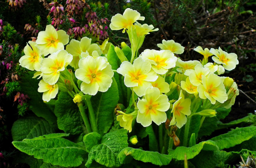

In [6]:
im = Image.open(dest)
im.to_thumb(256,256)

#### Downloading data

In [7]:
os.makedirs("flower_data/", exist_ok = True)
searches = ['primrose','orchid', 'tulip', 'geranium', 'rose']
path = Path('flower_data')

from tqdm import tqdm

for o in tqdm(searches):
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} flower photo', max_images = 100))
    time.sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

100%|██████████| 5/5 [01:11<00:00, 14.31s/it]


Removing images where downloading failed

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

### Training the model

Building a dataloader 

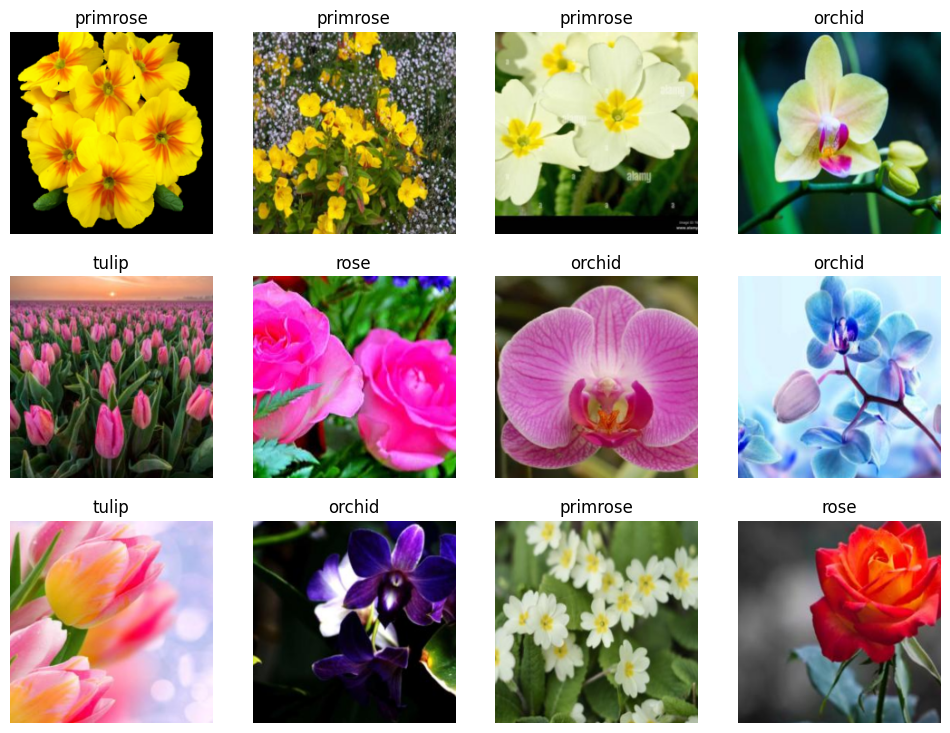

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5)
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.398225,0.178208,0.063291,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.246059,0.051664,0.021097,00:08
1,0.181904,0.051336,0.012658,00:08


### Data cleaning

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Most important losses : 

In [ ]:
interp.plot_top_losses(5, nrows=1)

### Using the model

In [ ]:
is_prim,_,probs = learn.predict(PILImage.create('primrose.jpg'))
print(f"This is a: {is_prim}.")
print(f"Probability it's a {is_prim}: {max(probs):.4f}")

### Exporting the model

In [ ]:
os.makedirs("models/", exist_ok = True)

In [ ]:
learn.export('models/first_classifier.pkl')